https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
datasetdir = "/content/drive/MyDrive/kaggle2/audio-images"
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras.utils as image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tensorflow.keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input

#VGG-16


In [3]:
batch_size = 20

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('class_1','class_0'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('class_1','class_0'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [4]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Treino e validação accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Treino e validação loss')
    
    plt.show()

In [5]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

553467096/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [7]:
img_path = '/content/drive/MyDrive/kaggle2/audio-images/class_1/1ID02_pd_2_0_0.png'
            
# loading the image: 
img = image.load_img(img_path, target_size=(224, 224))
# turn it into a numpy array
x = image.img_to_array(img)
print(np.min(x), np.max(x))
print(x.shape)
# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)
print(xs.shape)
# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)
# evaluate the model to extract the features
features = conv_model.predict(xs)
print(features.shape)

0.0 255.0
(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 1s 909ms/step
(1, 7, 7, 512)


In [8]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 34 images belonging to 2 classes.
Found 3 images belonging to 2 classes.


In [11]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [12]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
for layer in conv_model.layers:
    layer.trainable = False

In [14]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=8,
)

<ipython-input-15-fc8427383b4b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = full_model.fit_generator(


Epoch 1/8
2/2 [==============================] - 30s 15s/step - loss: 2.7542 - acc: 0.5588 - val_loss: 1.1090 - val_acc: 1.0000
Epoch 2/8
2/2 [==============================] - 26s 15s/step - loss: 3.6373 - acc: 0.4706 - val_loss: 1.4198 - val_acc: 0.6667
Epoch 3/8
2/2 [==============================] - 27s 14s/step - loss: 1.4618 - acc: 0.6765 - val_loss: 0.3113 - val_acc: 1.0000
Epoch 4/8
2/2 [==============================] - 23s 14s/step - loss: 1.5168 - acc: 0.6176 - val_loss: 0.6150 - val_acc: 0.6667
Epoch 5/8
2/2 [==============================] - 24s 12s/step - loss: 0.6842 - acc: 0.6765 - val_loss: 1.0062 - val_acc: 0.6667
Epoch 6/8
2/2 [==============================] - 25s 11s/step - loss: 0.7844 - acc: 0.5882 - val_loss: 0.2149 - val_acc: 1.0000
Epoch 7/8
2/2 [==============================] - 30s 22s/step - loss: 0.7593 - acc: 0.7647 - val_loss: 0.2092 - val_acc: 1.0000
Epoch 8/8
2/2 [==============================] - 22s 10s/step - loss: 0.6572 - acc: 0.8235 - val_loss: 0

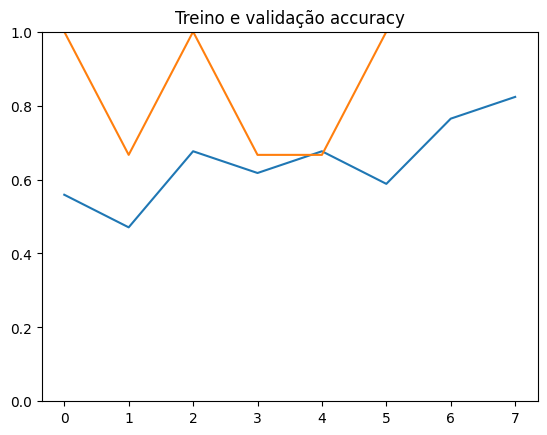

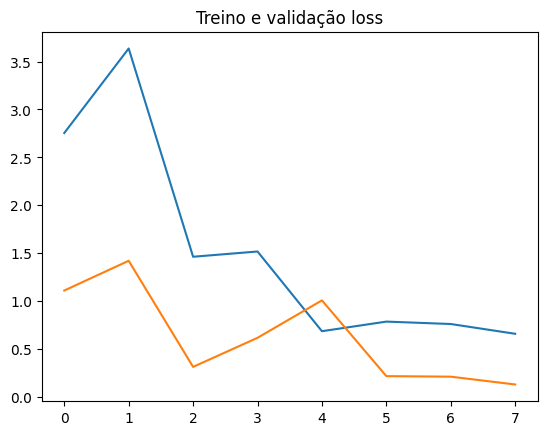

In [16]:
plot_history(history, yrange=(0,1))

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [21]:
y_true = val_dataset.classes

In [22]:
y_true

array([0, 1, 1], dtype=int32)

In [17]:
y_pred = full_model.predict(val_dataset)

1/1 [==============================] - 2s 2s/step


In [18]:
y_pred_res = [0 if x[0] <= 0.5 else 1 for x in y_pred]

In [25]:
fpr, tpr, _ = roc_curve(y_true, y_pred_res)
roc_auc = auc(fpr, tpr)

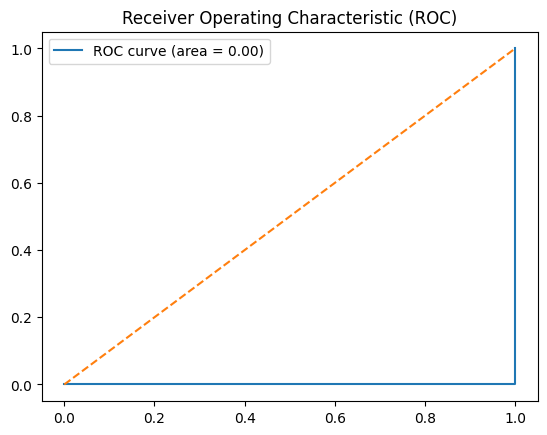

In [26]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

In [ ]:
type(val_dataset)

keras.preprocessing.image.DirectoryIterator

In [ ]:
y_true=np.array([x for _, x in val_dataset])

#contatenando as listas com as labels do valid_dataset
y_true1 = np.concatenate((y_true[0], y_true[1]), axis=None).tolist()

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import precision_score #precision
from sklearn.metrics import recall_score #recall
from sklearn.metrics import f1_score #f1-score
from sklearn.metrics import classification_report # metricas de validação


precision = precision_score(y_true1, y_pred_res)
print('Precision: %f' % precision)

In [ ]:
recall = recall_score(y_true1, y_pred_res)
print('Recall: %f' % recall)

In [ ]:
f1 = f1_score(y_true1, y_pred_res)
print('F1-Score: %f' % f1)

In [ ]:
print(classification_report(y_true1, y_pred_res))

#ResNet


In [ ]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 34 images belonging to 2 classes.
Found 3 images belonging to 2 classes.


In [ ]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
from keras.layers import Dropout

conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in conv_model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
predictions = keras.layers.Dense(2, activation='softmax')(x)

full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
)

Epoch 1/10
2/2 [==============================] - 22s 8s/step - loss: 8.3281 - acc: 0.4412 - val_loss: 0.5167 - val_acc: 0.6667
Epoch 2/10
2/2 [==============================] - 9s 5s/step - loss: 5.4677 - acc: 0.6176 - val_loss: 1.0390 - val_acc: 1.0000
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 8.3509 - acc: 0.4412 - val_loss: 0.8670 - val_acc: 0.6667
Epoch 4/10
2/2 [==============================] - 9s 5s/step - loss: 8.4001 - acc: 0.4118 - val_loss: 1.1467 - val_acc: 0.6667
Epoch 5/10
2/2 [==============================] - 7s 3s/step - loss: 3.7881 - acc: 0.7059 - val_loss: 1.1564 - val_acc: 0.6667
Epoch 6/10
2/2 [==============================] - 9s 3s/step - loss: 3.4002 - acc: 0.6765 - val_loss: 0.6785 - val_acc: 0.6667
Epoch 7/10
2/2 [==============================] - 7s 4s/step - loss: 3.3800 - acc: 0.6176 - val_loss: 0.6699 - val_acc: 0.6667
Epoch 8/10
2/2 [==============================] - 9s 4s/step - loss: 1.9549 - acc: 0.5882 - val_loss: 0.4892 -

In [ ]:
y_pred = full_model.predict(val_dataset)

1/1 [==============================] - 3s 3s/step


In [ ]:
y_pred_res = [0 if x[0] <= 0.5 else 1 for x in y_pred]

In [ ]:
y_true=np.array([x for _, x in val_dataset])

#contatenando as listas com as labels do valid_dataset
y_true = np.concatenate((y_true[0], y_true[1]), axis=None).tolist()

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcula a curva ROC e a AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_res)
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


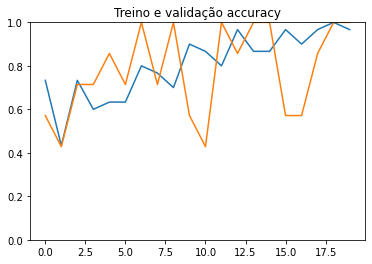

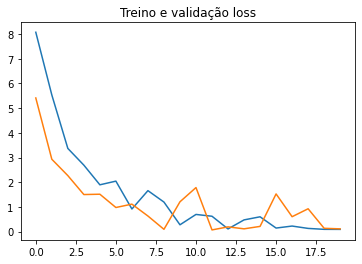

In [ ]:
plot_history(history, yrange=(0,1))

In [ ]:
# from keras.applications.resnet50 import preprocess_input

# img_path = '/content/drive/MyDrive/kaggle/audio-images/class_1/1_voice001.png'
# img = image.load_img(img_path, target_size=(224,224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# print(full_model.predict(x))
# plt.imshow(img)

##Matriz de Confusão

In [ ]:
y_pred = full_model.predict(val_dataset)

1/1 [==============================] - 3s 3s/step


In [ ]:
y_pred_res = [0 if x[0] <= 0.5 else 1 for x in y_pred]

In [ ]:
y_pred_res

[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
confusion_matrix = metrics.confusion_matrix(cat_score, cat_score2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

ValueError: ignored

In [ ]:
import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,2))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

train_labels, train_preds = true_and_predicted_labels(train_dataset)

1/1 [==============================] - 3s 3s/step


In [ ]:
def plot_pd_score(preds, labels, range=(0,1)):
    # get the cat score for all images
    cat_score = preds[:,1]
    # get the cat score for dogs
    # we use the true labels to select dog images
    dog_cat_score = cat_score[labels[:,0]>0.5]
    # and for cats
    cat_cat_score = cat_score[labels[:,0]<0.5]
    # just some plotting parameters
    params = {'bins':100, 'range':range, 'alpha':0.6}
    plt.hist(dog_cat_score, **params)
    plt.hist(cat_cat_score, **params)
    plt.yscale('log')

Parkinson é o laranja

saudavel é o azul

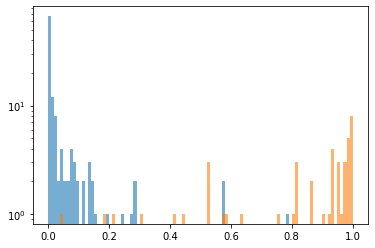

In [ ]:
plot_pd_score (train_preds, train_labels)

In [ ]:
def predicted_labels(preds, threshold):
    '''Turn predictions (floats in the last two dimensions) 
    into labels (0 or 1).'''
    pred_labels = np.zeros_like(preds)
    # cat score lower than threshold: set dog label to 1
    # cat score higher than threshold: set dog label to 0
    pred_labels[:,0] = preds[:,1]<threshold
    # cat score higher than threshold: set cat label to 1
    # cat score lower than threshold: set cat label to 0
    pred_labels[:,1] = preds[:,1]>=threshold
    return pred_labels

threshold = 0.4

train_pred_labels = predicted_labels(train_preds , threshold)
# print('Previstos labels:')
# print(train_pred_labels)
# print('Verdadeiros labels:')
# print(val_labels)

##Mal Classificados

In [ ]:
def erros(labels, pred_labels, print_report=True):
    def report(categ, n_misclassified, n_examples): 
        print('{:<4} {:>3} Erros amostras ({:4.2f}%)'.format(
            categ,
            n_misclassified, 
            100*(1-float(n_misclassified)/n_examples))
        )
    # total number of examples
    n_examples = len(labels)
    # total number of cats
    hc = sum(labels[:,0])
    # total number of dogs
    pd = sum(labels[:,1])
    # boolean mask for misidentified examples
    mask_all = pred_labels[:,0] != labels[:,0]
    # boolean mask for misidentified cats    
    mask_hc = np.logical_and(mask_all,labels[:,1]>0.5)
    # boolean mask for misidentified dogs    
    mask_pd = np.logical_and(mask_all,labels[:,1]<0.5)
    if print_report:
        report('total', sum(mask_all), n_examples)
        report('HC', sum(mask_hc), hc)
        report('PD', sum(mask_pd), pd)
    return mask_all, mask_hc, mask_pd

_ = erros(train_labels , train_pred_labels)

total   7 Erros amostras (95.81%)
HC     4 Erros amostras (96.72%)
PD     3 Erros amostras (93.33%)


In [ ]:
val_labels, val_preds = true_and_predicted_labels(val_dataset)
val_pred_labels = predicted_labels(val_preds, 0.4)
_ = erros(val_labels, val_pred_labels)

1/1 [==============================] - 2s 2s/step
total  10 Erros amostras (75.61%)
HC     8 Erros amostras (73.33%)
PD     2 Erros amostras (81.82%)


In [ ]:
dataset = val_dataset
misclassified_imgs = dict(pd=[], hc=[])
for i in range(len(dataset)):
    if i%100: 
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
    batch = dataset[i]
    batch_images = batch[0]
    batch_labels = batch[1]
    batch_preds = full_model.predict(batch_images)
    batch_pred_labels = predicted_labels(batch_preds, threshold=0.85)
    mask_all, mask_cats, mask_dogs = erros(
        batch_labels, 
        batch_pred_labels,
        print_report=False                                  
    )
    misclassified_imgs['pd'].extend(batch_images[mask_dogs])
    misclassified_imgs['hc'].extend(batch_images[mask_cats])

1/1 [==============================] - 1s 1s/step


In [ ]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')

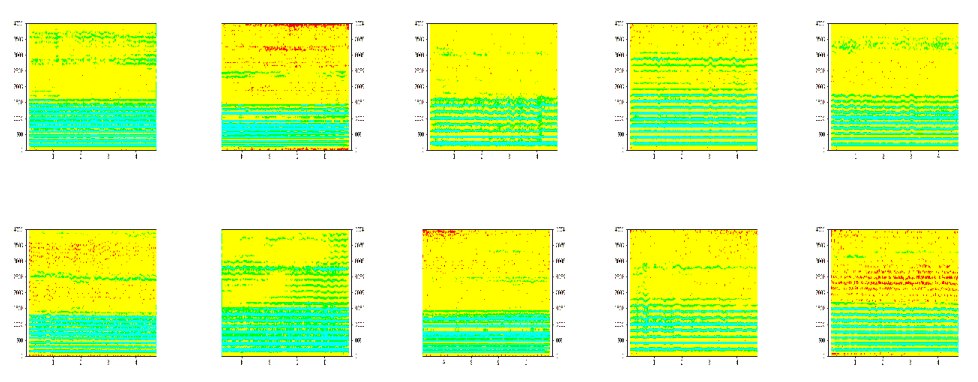

In [ ]:
plot_images(misclassified_imgs['hc'],0)

#VGG19


In [ ]:
from keras.layers import Dropout
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
x = keras.layers.Dense(100, activation='relu')(x)
x = Dropout(0.4)(x) # adicionando dropout
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
)

<ipython-input-54-cb9f918cb7ec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = full_model.fit_generator(


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 5.8916 - acc: 0.4118 

2/2 [==============================] - 47s 36s/step - loss: 5.8916 - acc: 0.4118 - val_loss: 2.1578 - val_acc: 0.6667
Epoch 2/10
2/2 [==============================] - 28s 14s/step - loss: 7.0335 - acc: 0.6176 - val_loss: 1.7005 - val_acc: 0.6667
Epoch 3/10
2/2 [==============================] - 29s 18s/step - loss: 6.5428 - acc: 0.5882 - val_loss: 1.2348 - val_acc: 0.6667
Epoch 4/10
2/2 [==============================] - 28s 19s/step - loss: 4.3557 - acc: 0.6471 - val_loss: 0.8430 - val_acc: 0.6667
Epoch 5/10
2/2 [==============================] - 28s 19s/step - loss: 4.8469 - acc: 0.5588 - val_loss: 0.4356 - val_acc: 0.6667
Epoch 6/10
2/2 [==============================] - 26s 11s/step - loss: 4.7665 - acc: 0.5294 - val_loss: 0.7042 - val_acc: 0.6667
Epoch 7/10
2/2 [==============================] - 27s 17s/step - loss: 4.3089 - acc: 0.5588 - val_loss: 0.6065 - val_acc: 0.6667
Epoch 8/10
2/2 [==============================] - 27s 12s/step - loss: 4.1515 - acc: 0.5588 - val_loss: 0.73

In [ ]:
y_pred = full_model.predict(val_dataset)

1/1 [==============================] - 2s 2s/step


In [ ]:
y_pred_res = [0 if x[0] <= 0.5 else 1 for x in y_pred]

In [ ]:
val_steps = val_dataset.samples // val_dataset.batch_size + 1
y_true = []
for i in range(val_steps):
    x, y = val_dataset.next()
    y_true.append(y)
y_true = np.concatenate(y_true, axis=0)


In [ ]:
y_true_res = [0 if x[0] <= 0.5 else 1 for x in y_true]

In [ ]:
y_true_res

[0, 1, 0]

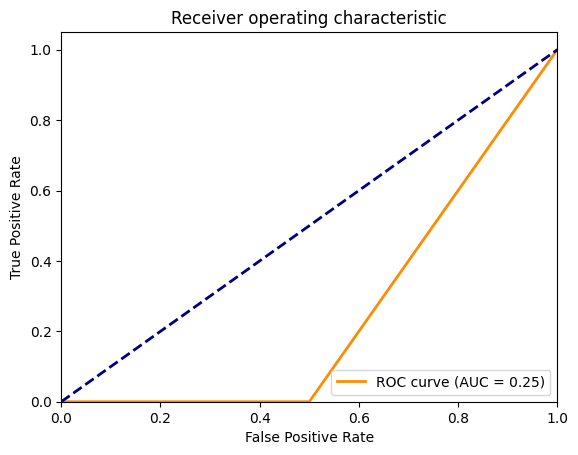

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcula a curva ROC e a AUC
fpr, tpr, _ = roc_curve(y_true_res, y_pred_res)
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true_res, y_pred_res).ravel()
sensitivity = tp / (tp + fn)

In [ ]:
sensitivity

0.0

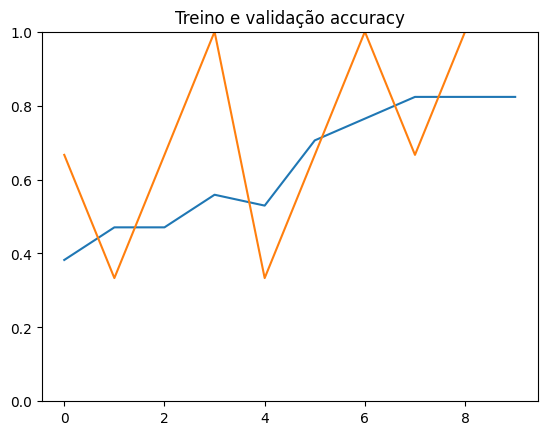

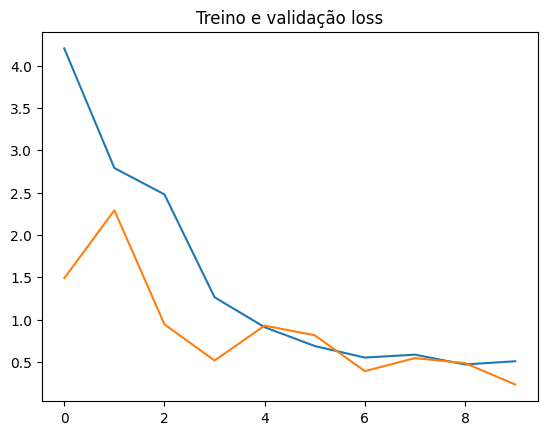

In [ ]:
plot_history(history, yrange=(0,1))

#ResNet-151

https://github.com/miladfa7/Image-Classification-Transfer-Learning/blob/master/ResNet_image_classification.ipynb

In [ ]:
import os
import tensorflow as tf #tf 2.0.0
import numpy as np

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
dataset_dir = os.path.join('/content/drive/MyDrive/kaggle2/imagens/')

Batch_size = 8
img_h = 256
img_w = 256
num_classes=2

classes = ['class_0', # 0
            'class_1']

/content/drive/MyDrive/kaggle2/imagens/training

In [ ]:
training_dir

'/content/drive/MyDrive/kaggle2/imagens/training'

In [ ]:
# train_gen = tf.keras.preprocessing.image_dataset_from_directory(
#                                              labels='inferred',
#                                              label_mode='int',
#                                              batch_size=Batch_size,
#                                              validation_split=0.1,
#                                              directory=os.path.join(dataset_dir, 'audio-images'),
#                                              shuffle=True,
#                                              color_mode='rgb',
#                                              interpolation='bilinear',
#                                              image_size=(img_h, img_w),
#                                              subset="training",
#                                              seed=0)

# valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
#                                              labels='inferred',
#                                              label_mode='int',
#                                              batch_size=Batch_size,
#                                              validation_split=0.1,
#                                              directory=os.path.join(dataset_dir, 'audio-images'), #mudar o dic 
#                                              shuffle=True,
#                                              color_mode='rgb',
#                                              interpolation='bilinear',
#                                              image_size=(img_h, img_w),
#                                              subset="validation",
#                                              seed=0)

# test_gen = tf.keras.preprocessing.image_dataset_from_directory(
#                                              labels='inferred',
#                                              label_mode='int',
#                                              batch_size=Batch_size,
#                                              validation_split=0.1,
#                                              directory=os.path.join(dataset_dir, 'audio-images'), #mudar o dic 
#                                              shuffle=True,
#                                              color_mode='rgb',
#                                              interpolation='bilinear',
#                                              image_size=(img_h, img_w),
#                                              subset="both",
#                                              seed=0)

In [ ]:

# Training


training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=Batch_size,
                                               classes=classes,
                                                class_mode='binary',
                                                shuffle=True,
                                               seed=None)  # targets are directly converted into one-hot vectors

# Validation
valid_dir = os.path.join(dataset_dir, 'valid')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(img_h, img_w),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=None)
# Test
test_dir = os.path.join(dataset_dir, 'testing')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(img_h, img_w),
                                             batch_size=10, 
                                             shuffle=False,
                                             classes=classes,
                                             seed=None,
                                             class_mode=None,
                                             )

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [ ]:
train_dataset, val_dataset = generators((224,224), preprocessing=ResNet_model)

Found 34 images belonging to 2 classes.
Found 3 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=20, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=val_dataset.n//val_dataset.batch_size
transfer_learning_history = model.fit_generator(generator=train_dataset,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=val_dataset,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                  callbacks=callbacks,
                  class_weight='auto',
                  
                    
)

<ipython-input-75-bedc11fce09e>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(generator=train_dataset,


ValueError: ignored